In [3]:
# for presentation purposes
import warnings
warnings.filterwarnings("ignore")

# wrangle
# from env import user, password, host
import os

# transform
import numpy as np
import pandas as pd

# visualize 
import matplotlib.pyplot as plt
import seaborn as sns

# working with dates
from datetime import datetime

# modeling
import statsmodels.api as sm
from statsmodels.tsa.api import Holt, ExponentialSmoothing

# evaluate
from sklearn.metrics import mean_squared_error
from math import sqrt 


from wrangle import wrangle_data
from model import get_baseline_table, evaluate, append_eval_df, get_eval_df

In [9]:
# plotting defaults
plt.rc('figure', figsize=(10, 8))
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)

In [2]:
# plot and evaluate 
def plot_and_eval(target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Test', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(yhat_df, target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()


In [3]:
get_baseline_table()

,model_type,target_var,rmse
0,simple_avg,fmr,104.0
1,simple_avg,mmr,233.0
2,simple_avg,diff,137.0
3,simple_avg,percent_diff,11.0
4,1_month_rolling_average,fmr,72.0
5,1_month_rolling_average,mmr,158.0
6,1_month_rolling_average,diff,98.0
7,1_month_rolling_average,percent_diff,8.0
8,6_month_rolling_avg,fmr,72.0
9,6_month_rolling_avg,mmr,162.0


In [4]:
df, train, validate, test = wrangle_data()

In [ ]:
round(train.shape[0] * .2, 0)

In [ ]:
validate = train[-12:]

In [ ]:
train = train[:-12]

In [ ]:
test = df[-12:]

validate = df[-36:-12]

train = df[:-36]

### Holt-Winters

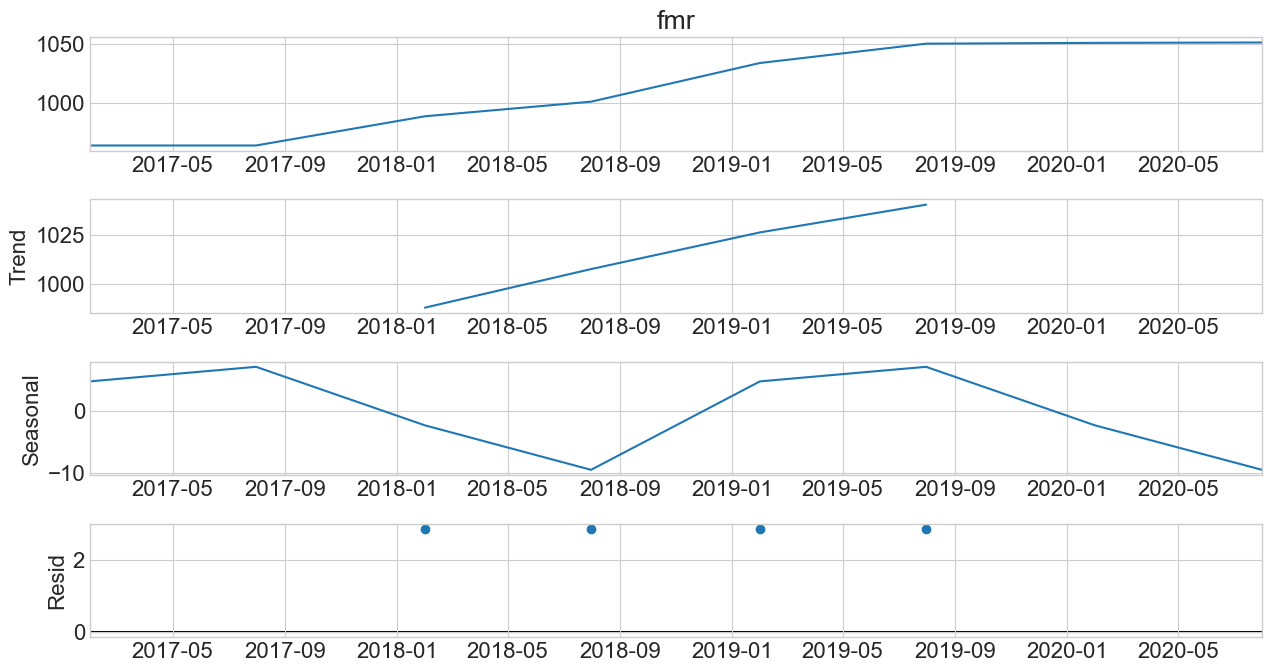

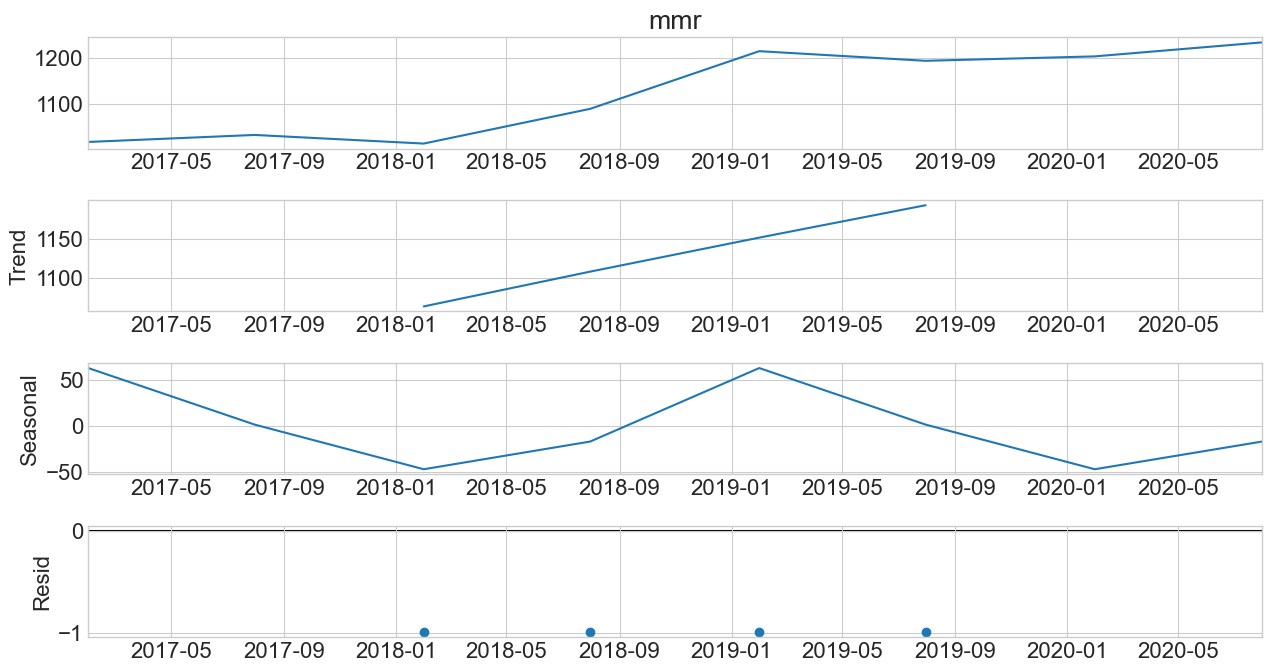

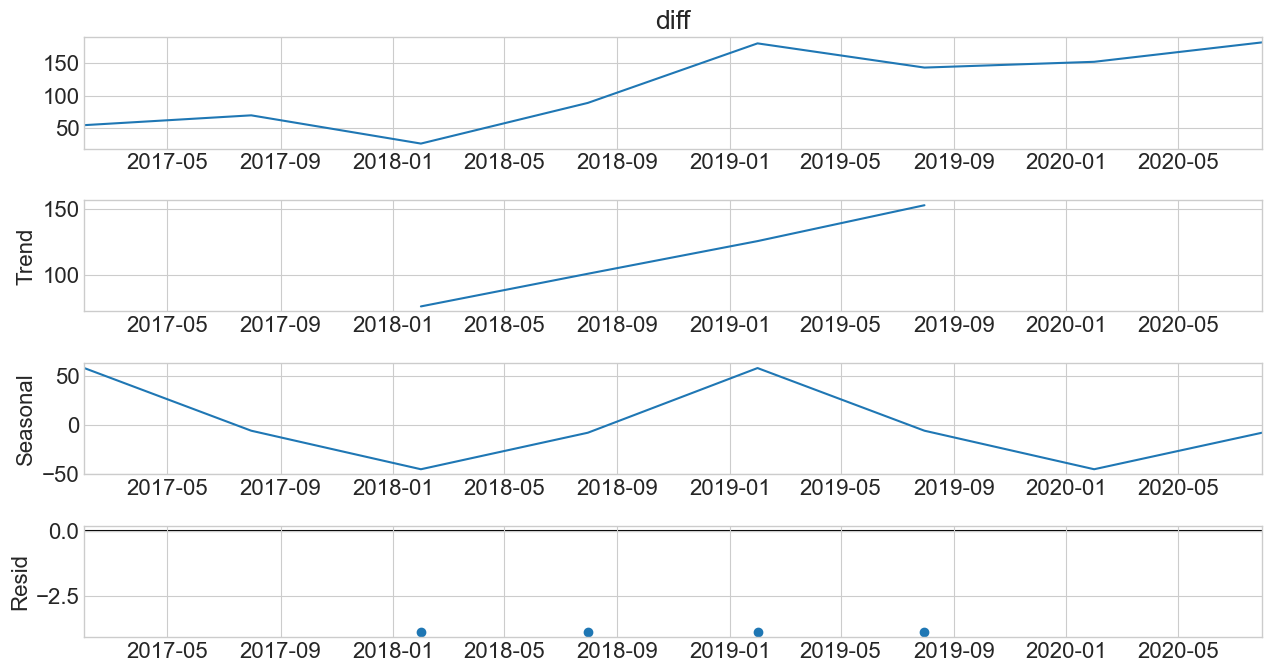

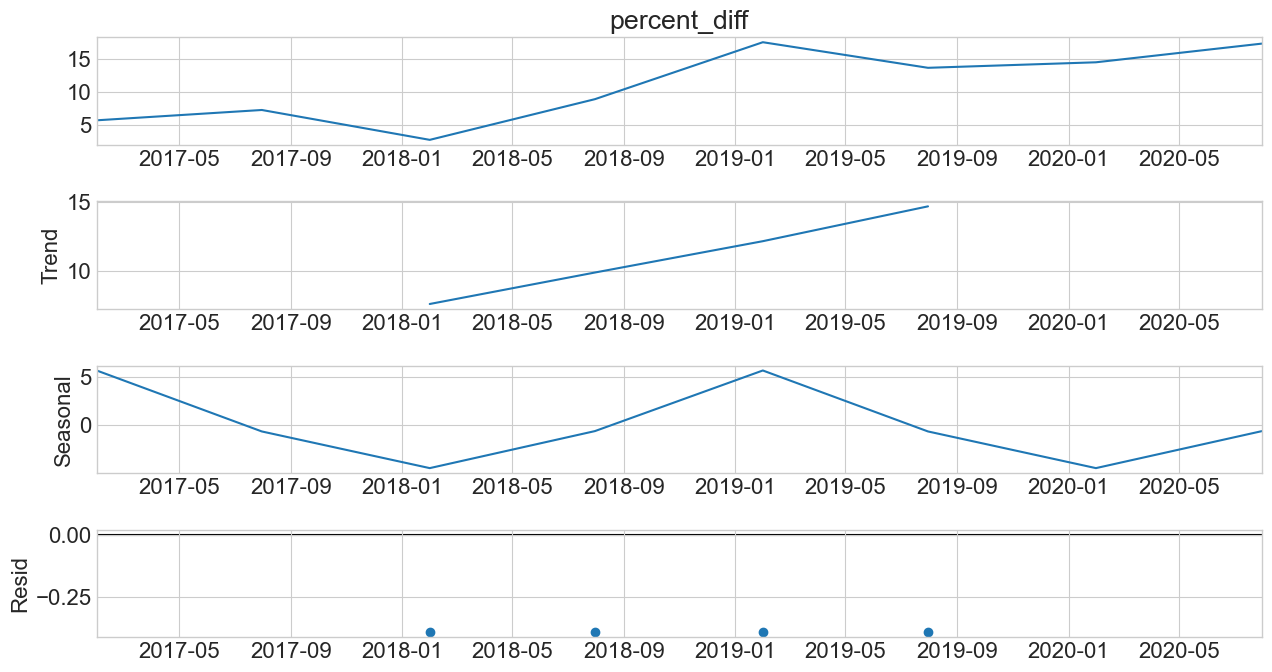

In [5]:
for col in train.columns:
    sm.tsa.seasonal_decompose(train[col].resample('6M').mean()).plot()

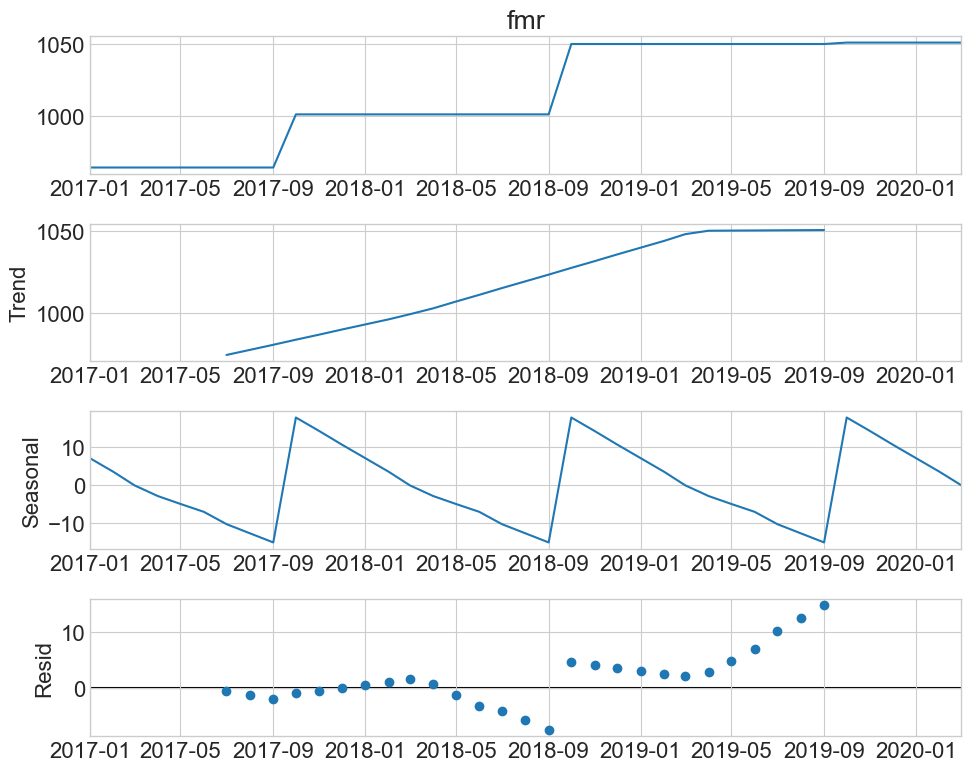

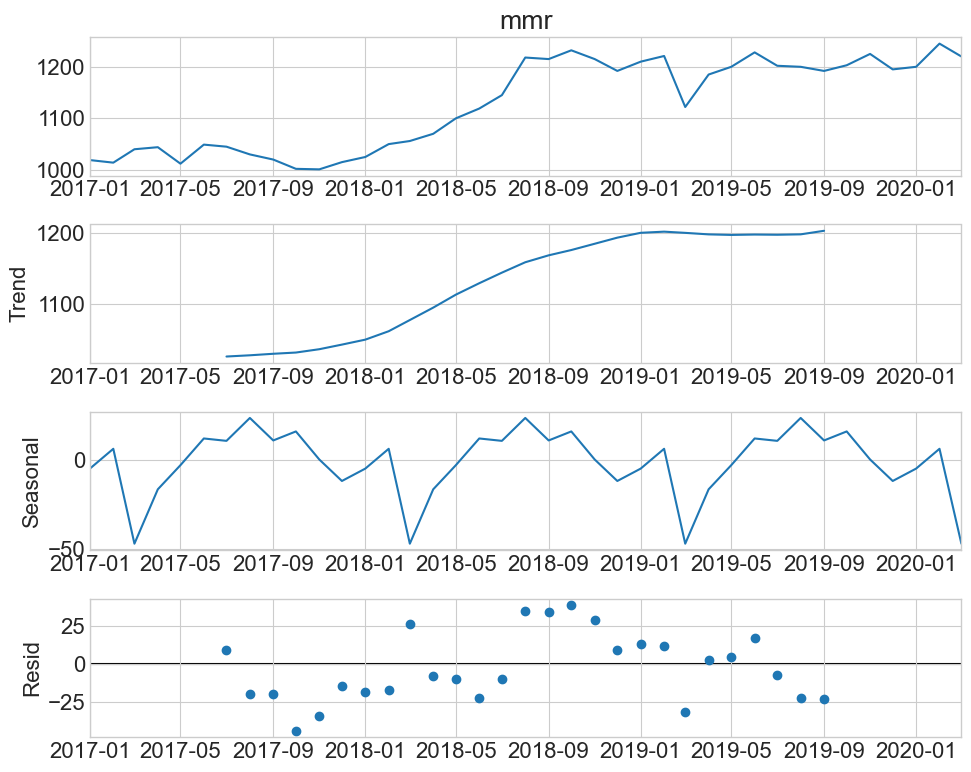

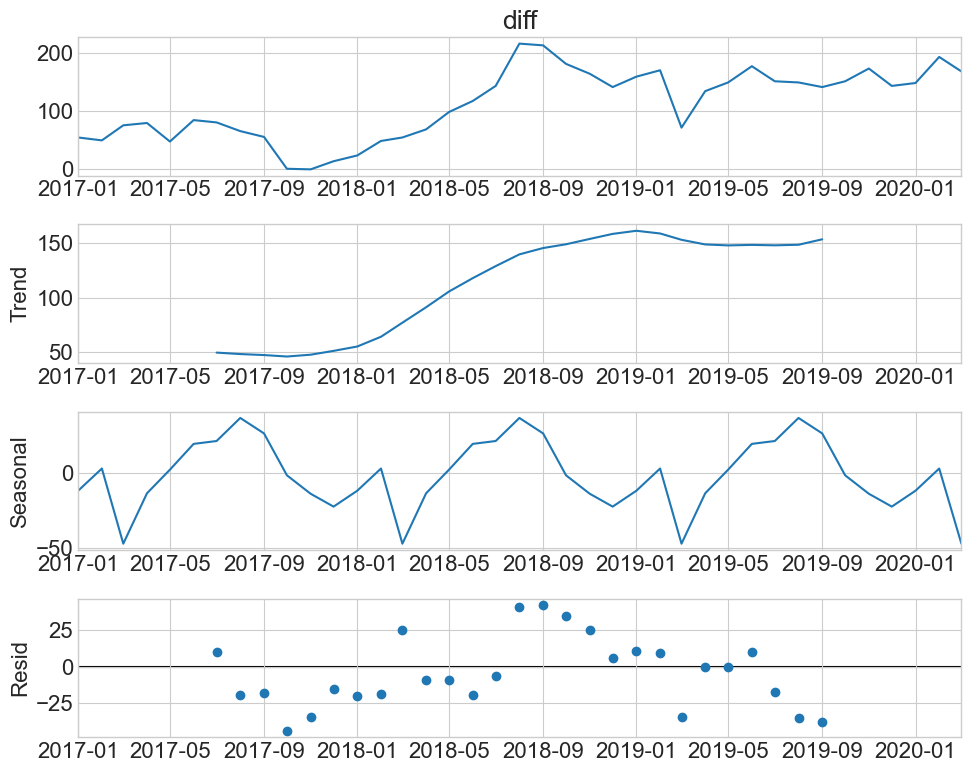

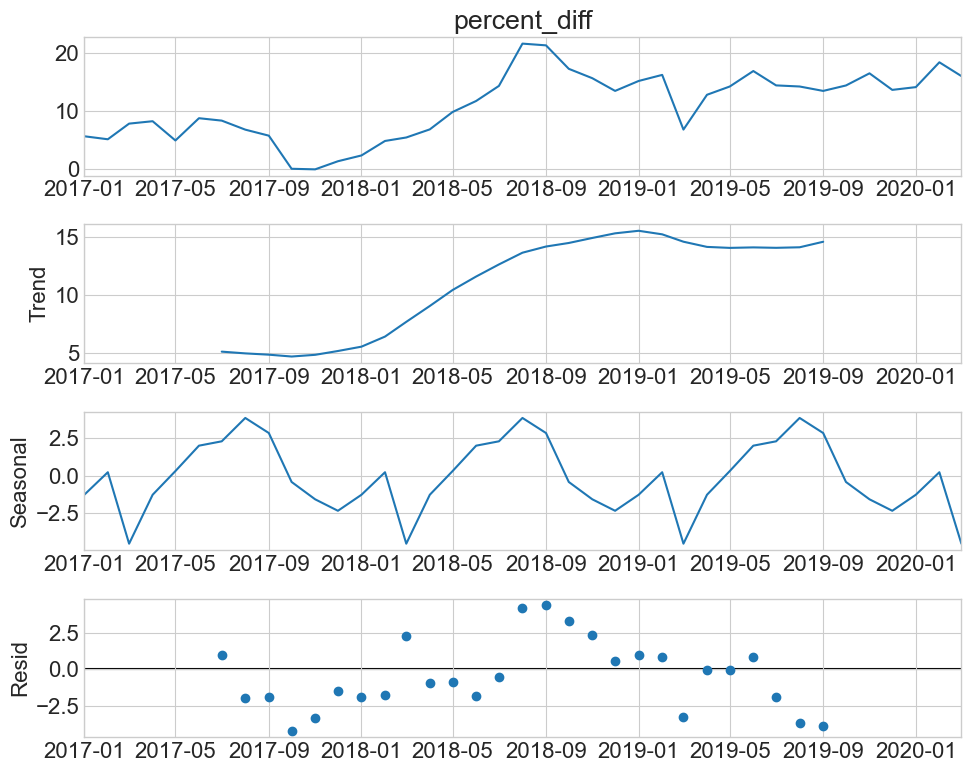

In [10]:
for col in train.columns:
    sm.tsa.seasonal_decompose(train[col]).plot()

#### Takeaways:
* There is a clear seasonality with all features, with the diff an percent diff looking very expectedly similar
* There is also a clear upward trend thats is apparent

In [8]:
yhat_df = pd.DataFrame(index=validate.index)

In [9]:
for col in train.columns:
    model = Holt(train[col], exponential=False, damped=True)
    model = model.fit(optimized=True)
    yhat_values = model.predict(start = validate.index[0],
                              end = validate.index[-1])
    yhat_df[col] = round(yhat_values, 2)


In [10]:
yhat_df.head()

,fmr,mmr,diff,percent_diff
2020-04-01,1052.74,1229.55,175.12,16.61
2020-05-01,1054.32,1234.29,177.90,16.86
2020-06-01,1055.87,1239.00,180.67,17.12
2020-07-01,1057.39,1243.68,183.42,17.37
2020-08-01,1058.89,1248.32,186.17,17.61


In [11]:
# for col in train.columns:
#     plot_and_eval(target_var=col)

In [12]:
# get eval df
eval_df = get_eval_df()

# for each col
for col in train.columns:

    # get the input for the target var
    new_eval_df = append_eval_df(yhat_df, model_type = 'holts_optimized', 
                            target_var = col)
    
    # concat it on the eval_df
    eval_df = pd.concat([eval_df, new_eval_df])

In [13]:
get_baseline_table()

,model_type,target_var,rmse
0,simple_avg,fmr,104.0
1,simple_avg,mmr,233.0
2,simple_avg,diff,137.0
3,simple_avg,percent_diff,11.0
4,1_month_rolling_average,fmr,72.0
5,1_month_rolling_average,mmr,158.0
6,1_month_rolling_average,diff,98.0
7,1_month_rolling_average,percent_diff,8.0
8,6_month_rolling_avg,fmr,72.0
9,6_month_rolling_avg,mmr,162.0


In [14]:
eval_df

,model_type,target_var,rmse
0,holts_optimized,fmr,53.0
0,holts_optimized,mmr,99.0
0,holts_optimized,diff,71.0
0,holts_optimized,percent_diff,6.0


#### Takeaway:
* For a basic holts_optimized model, **mmr** out performs the baseline, all others do not outperform the baseline

In [15]:
# function
def get_holts_optimized():
    '''
    This functions models and predicts each column in the global train variable and places the predicted values in a df
    '''
    # intialize df
    d = pd.DataFrame(index=validate.index)

    # for each column in train
    for col in train.columns:

        # initialize a model for the column
        model = Holt(train[col], exponential=False, damped=True)

        # fit the model with optimizaiton 
        model = model.fit(optimized=True)

        # get the predicted values, using the first date in the test index and th last date in the index as start and end positions
        values = model.predict(start = validate.index[0],
                                  end = validate.index[-1])

        # add the values to the dataframe
        d[col] = round(values, 2)

    # exit the function and return the df
    return d

In [16]:
# get_holts_optimized()
# success

## Holt's Seasonal Trend
* Seasonal Periods
    * The seasonal period is one year for all features based on the decomposition plots
* Trend
    * The trend appears to be additive
* Seasonal
    * I believe it is additive

In [17]:
# initial
hst_fit1 = ExponentialSmoothing(train['diff'], seasonal_periods=12, trend='add', seasonal='add', damped=True).fit(optimized=True)

yhat_df = pd.DataFrame({'diff': hst_fit1.forecast(test.shape[0] + 1)},
                          index=test.index)
yhat_df

,diff
2022-04-01,NaN
2022-05-01,NaN
2022-06-01,NaN
2022-07-01,NaN
2022-08-01,NaN
2022-09-01,NaN
2022-10-01,NaN
2022-11-01,NaN
2022-12-01,NaN
2023-01-01,NaN


ValueError: Found input variables with inconsistent numbers of samples: [24, 12]

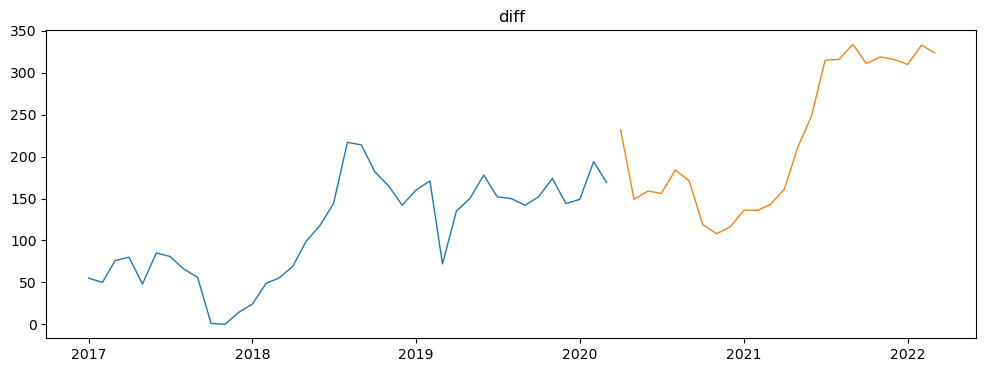

In [18]:
plot_and_eval('diff')

In [38]:
# make programmatic
def get_holt_seasonal_trend_forecast(validate=validate, seasonal_periods=12, trend='add', seasonal='add', damped=True):
    '''
    This function takes in hyperparameteers for the holts seasonal trend model and outputs a df with each forecast for each column in the train df
    '''
    # initialize dictionary
    d = pd.DataFrame(index = validate.index)

    # for each column in train
    for col in train.columns:

        # fit on the columns with 12 month seasonality and additive trend and seasonals, with a damped
        hst_fit = ExponentialSmoothing(train[col], seasonal_periods=seasonal_periods, trend=trend, seasonal=seasonal, damped=damped).fit(optimized=True)

        # get forecast for the length or shape
        hst_forecast = hst_fit.forecast(validate.shape[0] + 1)

        # add the forecasted information to the dictionary with only the test index
        d[col] = hst_forecast

    # exit function and return the df
    return d

In [39]:
get_holt_seasonal_trend_forecast()

,fmr,mmr,diff,percent_diff
2020-04-01,1049.576825,1246.095064,195.294518,18.640075
2020-05-01,1048.235850,1249.478010,198.997026,18.963371
2020-06-01,1046.934137,1276.833521,226.677415,21.719085
2020-07-01,1045.670503,1274.689077,225.059039,21.576084
2020-08-01,1044.443938,1292.682593,243.365428,23.379910
2020-09-01,1043.253334,1284.842764,236.002321,22.635567
2020-10-01,1071.097858,1287.257707,209.964764,19.652390
2020-11-01,1069.976460,1287.781743,210.683582,19.732822
2020-12-01,1068.888216,1274.187380,197.360662,18.473207
2021-01-01,1067.846475,1285.318834,208.462501,19.548034


In [ ]:
# for col in train.columns:
#     new_eval_df = append_eval_df(yhat_df, model_type = 'holts_seasonal_optimized', 
#                             target_var = col)

#     eval_df = pd.concat([eval_df, new_eval_df])

# eval_df    

# Predict Based on Previous Cycle

In [ ]:
len(test)

In [ ]:
d = (train.loc['2021-02':'2022'] + train.diff(12).mean())

In [ ]:
d.index = test.index

In [ ]:
for col in train.columns:
    plot_and_eval(target_var = col)
    eval_df = append_eval_df(d, model_type = 'previous year', target_var = col)


# Get model into model.py

In [21]:
def get_models():
    '''
    This function takes the two best performeing models and presents them in a datframe format
    
    '''
    # get eval_df
    eval_df = get_eval_df()
    
    # Create list of baseline tables with the model name as a pairt
    models_and_type = [(get_holts_optimized(), 'holts_optimized'), (get_holt_seasonal_trend_forecast(), 'holts_seasonal')]

    # for each df and modeltype
    for model, model_type in models_and_type:

        # for each columns in df
        for col in train.columns:

            # add to the eval_df
            new_eval_df = append_eval_df(model, model_type=model_type,
                                    target_var=col)
            
            # concat new eval with old eval
            eval_df = pd.concat([eval_df, new_eval_df])
    
    # exit and return eval df with all evaluations
    return eval_df.reset_index().drop('index', axis=1)


In [ ]:
get_models()

In [ ]:
get_baseline_table()

In [22]:
def get_all_models():
    '''
    This function returns a df with all models present
    '''
    return pd.concat([get_baseline_table(), get_models()]).reset_index().drop('index', axis=1)

In [ ]:
get_all_models()

In [29]:
validate = test

In [ ]:
len(validate)

In [30]:
append_eval_df, evaluate

(<function model.append_eval_df(yhat_df, model_type, target_var)>,
 <function model.evaluate(yhat_df, target_var)>)

In [23]:
def get_holts_seasonal_test():
    '''
    This function takes the two best performeing models and presents them in a datframe format
    
    '''
    # get eval_df
    eval_df = get_eval_df()
    
    # Create list of baseline tables with the model name as a pairt
    models_and_type = [(get_holt_seasonal_trend_forecast(), 'holts_seasonal')]

    # for each df and modeltype
    for model, model_type in models_and_type:

        # for each columns in df
        for col in train.columns:

            # add to the eval_df
            new_eval_df = append_eval_df(model, model_type=model_type,
                                    target_var=col)
            
            # concat new eval with old eval
            eval_df = pd.concat([eval_df, new_eval_df])
    
    # exit and return eval df with all evaluations
    return eval_df.reset_index().drop('index', axis=1)


In [35]:
df, train, validate, test = wrangle_data()

In [45]:
test

,fmr,mmr,diff,percent_diff
2022-04-01,1165.0,1540.0,375.0,32.188841
2022-05-01,1165.0,1542.0,377.0,32.360515
2022-06-01,1165.0,1548.0,383.0,32.875536
2022-07-01,1165.0,1550.0,385.0,33.047210
2022-08-01,1165.0,1555.0,390.0,33.476395
2022-09-01,1165.0,1549.0,384.0,32.961373
2022-10-01,1282.0,1513.0,231.0,18.018721
2022-11-01,1286.0,1495.0,209.0,16.251944
2022-12-01,1286.0,1502.0,216.0,16.796267
2023-01-01,1286.0,1502.0,216.0,16.796267


In [46]:
get_holt_seasonal_trend_forecast(validate=test)

,fmr,mmr,diff,percent_diff
2022-04-01,NaN,NaN,NaN,NaN
2022-05-01,NaN,NaN,NaN,NaN
2022-06-01,NaN,NaN,NaN,NaN
2022-07-01,NaN,NaN,NaN,NaN
2022-08-01,NaN,NaN,NaN,NaN
2022-09-01,NaN,NaN,NaN,NaN
2022-10-01,NaN,NaN,NaN,NaN
2022-11-01,NaN,NaN,NaN,NaN
2022-12-01,NaN,NaN,NaN,NaN
2023-01-01,NaN,NaN,NaN,NaN


In [5]:
# make programmatic
def get_holt_seasonal_trend_forecast_test(seasonal_periods=12, trend='add', seasonal='add', damped=True):
    '''
    This function takes in hyperparameteers for the holts seasonal trend model and outputs a df with each forecast for each column in the train df
    '''
    # initialize dictionary
    d = pd.DataFrame(index = (pd.concat([validate, test]).index))

    # for each column in train
    for col in train.columns:

        # fit on the columns with 12 month seasonality and additive trend and seasonals, with a damped
        hst_fit = ExponentialSmoothing(train[col], seasonal_periods=seasonal_periods, trend=trend, seasonal=seasonal, damped=damped).fit(optimized=True)

        # get forecast for the length or shape
        hst_forecast = hst_fit.forecast(validate.shape[0] + test.shape[0] + 1)

        # add the forecasted information to the dictionary with only the test index
        d[col] = round(hst_forecast, 2)

    # exit function and return the df
    return d

In [56]:
df[-36:]

,fmr,mmr,diff,percent_diff
2020-04-01,1051.0,1283.0,232.0,22.074215
2020-05-01,1051.0,1200.0,149.0,14.176974
2020-06-01,1051.0,1210.0,159.0,15.128449
2020-07-01,1051.0,1207.0,156.0,14.843007
2020-08-01,1051.0,1235.0,184.0,17.507136
2020-09-01,1051.0,1222.0,171.0,16.270219
2020-10-01,1114.0,1233.0,119.0,10.682226
2020-11-01,1114.0,1222.0,108.0,9.694794
2020-12-01,1114.0,1230.0,116.0,10.412926
2021-01-01,1114.0,1250.0,136.0,12.208259


In [47]:
pd.concat([train[col], validate[col]])

2017-01-01     55.0
2017-02-01     50.0
2017-03-01     76.0
2017-04-01     80.0
2017-05-01     48.0
              ...  
2021-11-01    319.0
2021-12-01    316.0
2022-01-01    310.0
2022-02-01    333.0
2022-03-01    324.0
Freq: MS, Name: diff, Length: 63, dtype: float64

In [72]:
# get_holt_seasonal_trend_forecast_test()

# getting baseline on test

In [63]:
from model import get_baseline_rolling_average

In [6]:
def get_baseline_rolling_average_test(period = 1):
    '''
    This function takes in a period as an argument and calculates the rolling/moving average based on that period.
    It then returns the rolling average for each column in train in a dartaframe
    '''
    # create dict
    d = pd.DataFrame(index=pd.concat([validate, test]).index)
    
    # for each col in train
    for col in train.columns:

        # get the rolling mean
        rolling = round(train[col].rolling(period).mean()[-1], 2)
        
        # add column with rolling mean in it
        d[col] = rolling

    # return the df
    return d

# evaluation function to compute rmse
def evaluate_test(yhat_df, target_var):
    '''
    This function will take the actual values of the target_var from test, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    
    # gets the rmse and rounds to 0 decimals places
    rmse = round(sqrt(mean_squared_error(test[target_var], yhat_df[target_var])), 0)
    
    # returns the rmse 
    return rmse

# function to store rmse for comparison purposes
def append_eval_df_test(yhat_df, model_type, target_var):
    '''
    this function takes in the yhat_df used, type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    # setting start time for yhat_df
    yhat_start = test.index[0]
    
    # getting test size df
    yhat_df = yhat_df[yhat_start:]
    
    # get the rmse
    rmse = evaluate_test(yhat_df, target_var)
    
    # create a dictionary to store relevant information
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    
    # convert to df
    d = pd.DataFrame(d)
    
    # return the df
    return d

def get_test():
    '''
    This function creates a datafram with the baseline model rmse's for each feature in the tain df
    '''
    # get eval_df
    eval_df = get_eval_df()
    
    # Create list of baseline tables with the model name as a pairt
    models_and_type = [(get_baseline_rolling_average_test(), '1_month_rolling_average'), (get_holt_seasonal_trend_forecast_test(), 'holts_seasonal')]

    # for each df and modeltype
    for model, model_type in models_and_type:
        
        # for each columns in df
        for col in train.columns:

            # add to the eval_df
            new_eval_df = append_eval_df_test(model, model_type=model_type,
                                    target_var=col)
            
            # concat new eval with old eval
            eval_df = pd.concat([eval_df, new_eval_df])
    
    # exit and return eval df with all evaluations
    return eval_df.reset_index().drop('index', axis=1)

In [7]:
from wrangle import wrangle_data

In [8]:
df, train, validate, test = wrangle_data()

In [13]:
get_test()

,model_type,target_var,rmse
0,1_month_rolling_average,fmr,184.0
1,1_month_rolling_average,mmr,306.0
2,1_month_rolling_average,diff,155.0
3,1_month_rolling_average,percent_diff,12.0
4,holts_seasonal,fmr,157.0
5,holts_seasonal,mmr,137.0
6,holts_seasonal,diff,80.0
7,holts_seasonal,percent_diff,7.0


In [10]:
def get_eval_df():
    '''
    Creates a dataframe to hold the model target and rmse
    '''
    # Create the empty dataframe
    eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
    
    # exit and return the empty df
    return eval_df

In [153]:
get_baseline_rolling_average_test()

,fmr,mmr,diff,percent_diff
2022-04-01,1051.0,1220.0,169.0,16.08
2022-05-01,1051.0,1220.0,169.0,16.08
2022-06-01,1051.0,1220.0,169.0,16.08
2022-07-01,1051.0,1220.0,169.0,16.08
2022-08-01,1051.0,1220.0,169.0,16.08
2022-09-01,1051.0,1220.0,169.0,16.08
2022-10-01,1051.0,1220.0,169.0,16.08
2022-11-01,1051.0,1220.0,169.0,16.08
2022-12-01,1051.0,1220.0,169.0,16.08
2023-01-01,1051.0,1220.0,169.0,16.08


In [127]:
df, train, test, validate = wrangle_data()

In [144]:
start = test.index.strftime(date_format='%Y-%m-%d')[0]

In [150]:
start2 = test.index[0]

In [145]:
(start)

'2020-04-01'

In [151]:
df[start2:]

,fmr,mmr,diff,percent_diff
2020-04-01,1051.0,1283.0,232.0,22.074215
2020-05-01,1051.0,1200.0,149.0,14.176974
2020-06-01,1051.0,1210.0,159.0,15.128449
2020-07-01,1051.0,1207.0,156.0,14.843007
2020-08-01,1051.0,1235.0,184.0,17.507136
2020-09-01,1051.0,1222.0,171.0,16.270219
2020-10-01,1114.0,1233.0,119.0,10.682226
2020-11-01,1114.0,1222.0,108.0,9.694794
2020-12-01,1114.0,1230.0,116.0,10.412926
2021-01-01,1114.0,1250.0,136.0,12.208259


In [96]:
yhat_start = test.index[0]

In [3]:
from model import get_test

In [4]:
get_test()

,model_type,target_var,rmse
0,1_month_rolling_average,fmr,184.0
1,1_month_rolling_average,mmr,306.0
2,1_month_rolling_average,diff,155.0
3,1_month_rolling_average,percent_diff,12.0
4,holts_seasonal,fmr,157.0
5,holts_seasonal,mmr,137.0
6,holts_seasonal,diff,80.0
7,holts_seasonal,percent_diff,7.0


#### Takeaways:
* This means holts seasonal trencd can predict FMR with an error of \\$157

##### Questions/Notes:
* How does this benefit the consumer?
* How does this benefit HUD?
* How can this data be used?
* How can we interpret these RMSE's for each group?
    * With RMSE, is there something similar to an IQR we can use to provide a range of prediocted values based on the RMSE?